In [1]:
library(foreign)
library(ggplot2)
library(VGAM)
library(boot)

Loading required package: stats4
Loading required package: splines

Attaching package: 'boot'

The following objects are masked from 'package:VGAM':

    logit, simplex



### Examples of zero-truncated negative binomial

### Description of the data

In [2]:
dat <- read.dta("./datasets/ztp.dta")

dat <- within(dat, {hmo <- factor(hmo) 
                    died <- factor(died) })

summary(dat)

      stay             age        hmo      died   
 Min.   : 1.000   Min.   :1.000   0:1254   0:981  
 1st Qu.: 4.000   1st Qu.:4.000   1: 239   1:512  
 Median : 8.000   Median :5.000                   
 Mean   : 9.729   Mean   :5.234                   
 3rd Qu.:13.000   3rd Qu.:6.000                   
 Max.   :74.000   Max.   :9.000                   

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


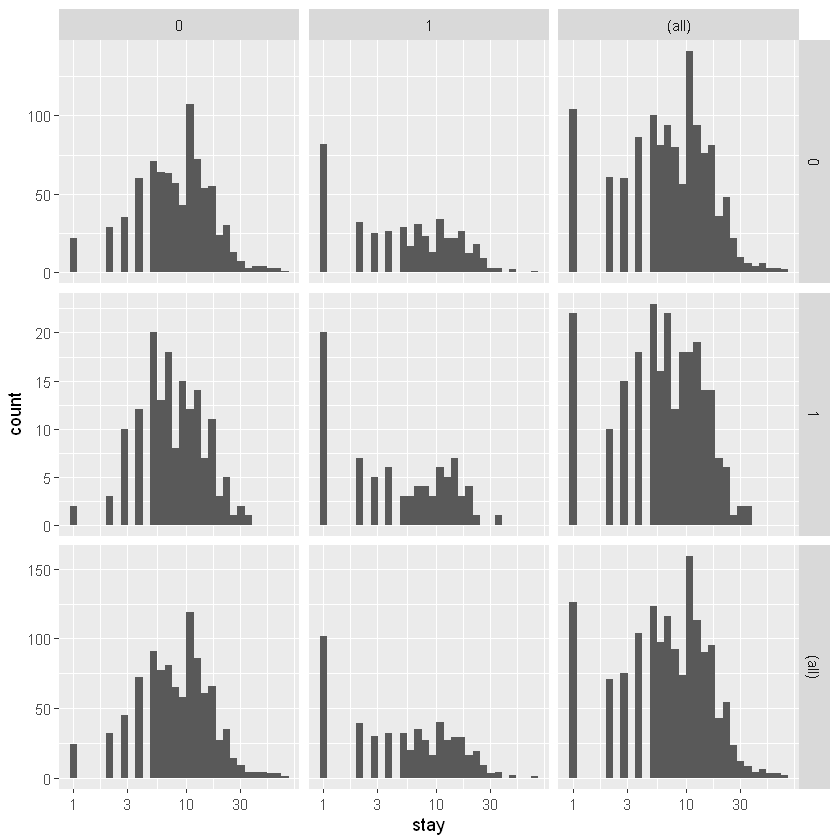

In [3]:
ggplot(dat, aes(stay)) + geom_histogram() + scale_x_log10() + facet_grid(hmo ~ 
    died, margins = TRUE, scales = "free_y")

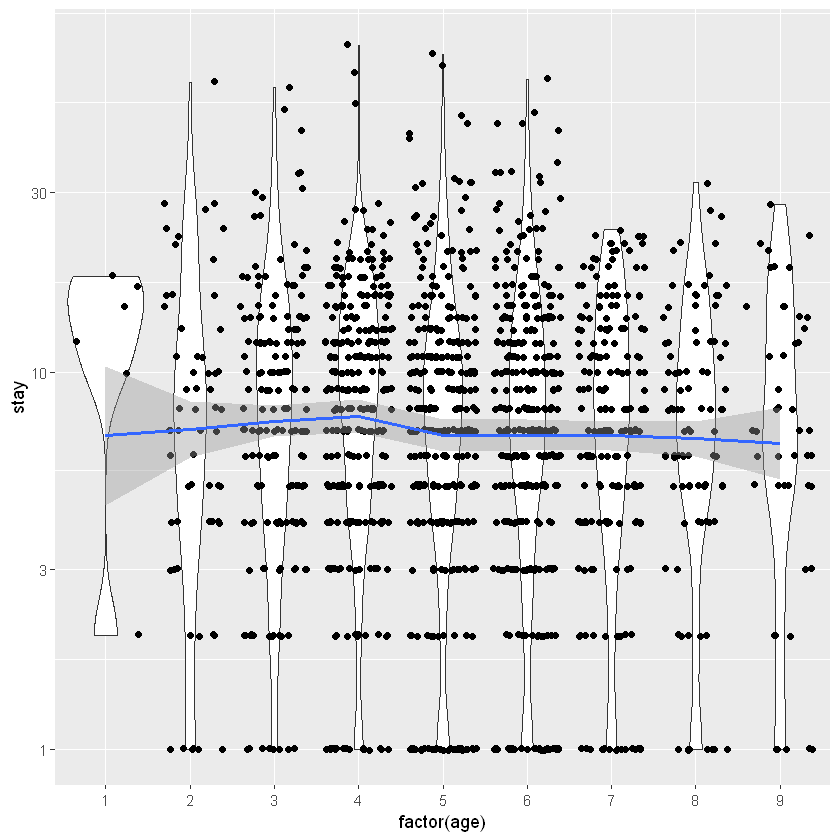

In [4]:
ggplot(dat, aes(factor(age), stay)) +
    geom_violin() + geom_jitter(size=1.5) + scale_y_log10() + 
    stat_smooth(aes(x = age, y = stay, group=1), method="loess")

Warning message:
"Removed 50 rows containing missing values (geom_bar)."

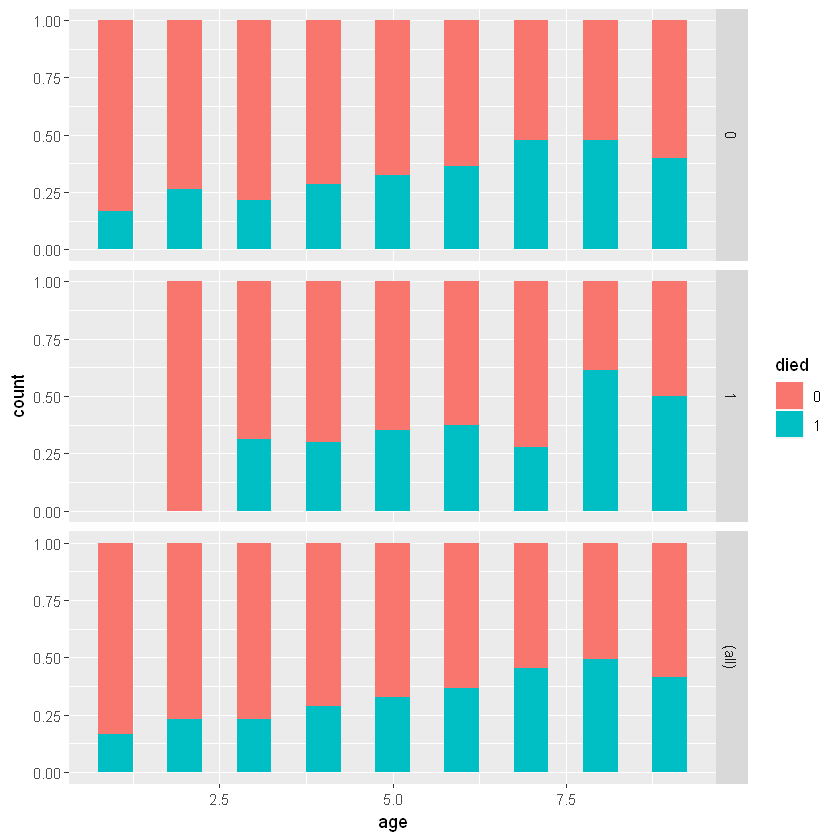

In [5]:
ggplot(dat, aes(age, fill=died)) +
    geom_histogram(binwidth=.5, position="fill") + facet_grid(hmo ~ ., margins=TRUE)

### Analysis methods you might consider

### Zero-truncated negative binomial regression

In [6]:
m1 <- vglm(stay ~ age + hmo + died, family = posnegbinomial(), data = dat)

In [7]:
summary(m1)


Call:
vglm(formula = stay ~ age + hmo + died, family = posnegbinomial(), 
    data = dat)

Pearson residuals:
                  Min      1Q  Median     3Q    Max
loglink(munb)  -1.284 -0.6845 -0.2020 0.4504 8.2284
loglink(size) -13.924 -0.2586  0.4217 0.7541 0.8668

Coefficients: 
              Estimate Std. Error z value Pr(>|z|)    
(Intercept):1  2.40833    0.07158  33.645  < 2e-16 ***
(Intercept):2  0.56864    0.05489  10.359  < 2e-16 ***
age           -0.01569    0.01304  -1.204    0.229    
hmo1          -0.14706    0.05922  -2.483    0.013 *  
died1         -0.21777    0.04615  -4.719 2.38e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Names of linear predictors: loglink(munb), loglink(size)

Log-likelihood: -4755.28 on 2981 degrees of freedom

Number of Fisher scoring iterations: 4 

No Hauck-Donner effect found in any of the estimates


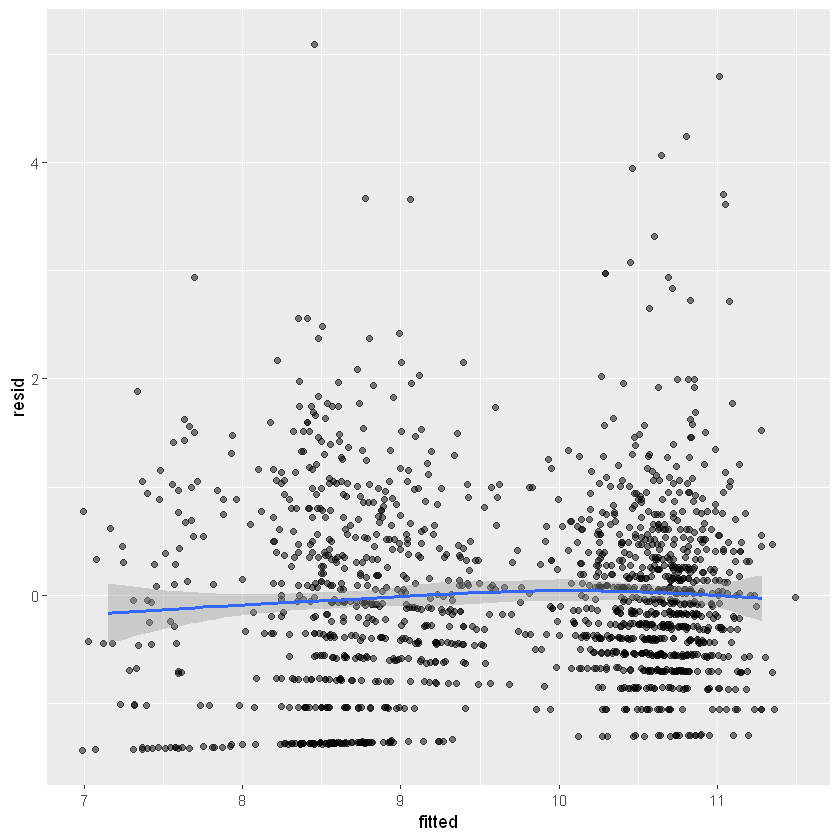

In [8]:
output <- data.frame(resid = resid(m1)[, 1], fitted = fitted(m1))
ggplot(output, aes(fitted, resid)) + 
    geom_jitter(position = position_jitter(width = 0.25), alpha = 0.5) + stat_smooth(method = "loess")

Smoothing formula not specified. Using: y ~ x


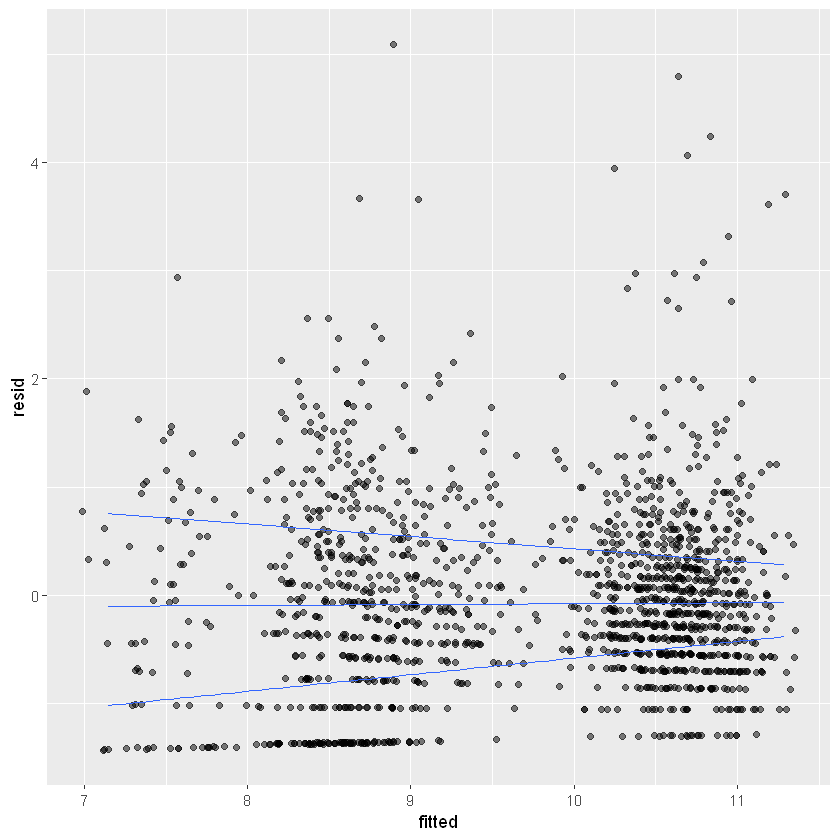

In [9]:
ggplot(output, aes(fitted, resid)) +
    geom_jitter(position=position_jitter(width=.25), alpha=.5) + stat_quantile(method="rq")

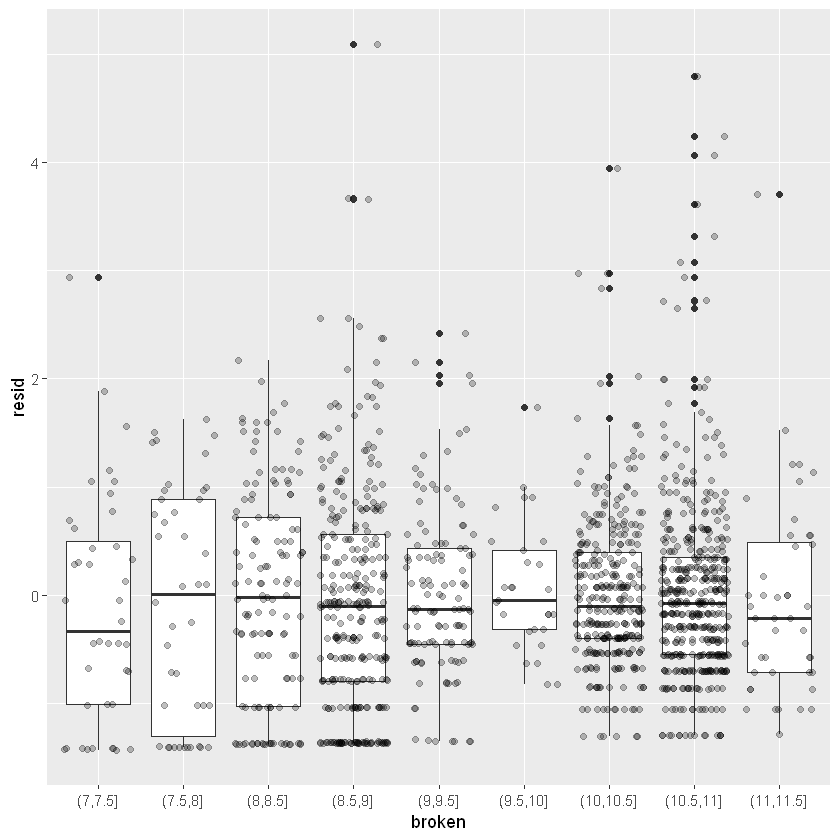

In [10]:
output <- within(output, {broken <- cut(fitted, hist(fitted, plot=FALSE)$breaks) })
ggplot(output, aes(broken, resid)) + geom_boxplot() + geom_jitter(alpha=.25)

In [11]:
m2 <- vglm(formula = stay ~ age + hmo + died, family = pospoisson(), data = dat)

In [12]:
## change in deviance
(dLL <- 2 * (logLik(m1) - logLik(m2)))

[1] 4307.039

In [13]:
## p-value, 1 df---the overdispersion parameter
pchisq(dLL, df = 1, lower.tail = FALSE)

[1] 0

In [14]:
dput(round(coef(m1),3))

c(`(Intercept):1` = 2.408, `(Intercept):2` = 0.569, age = -0.016, 
hmo1 = -0.147, died1 = -0.218)


In [15]:
f <- function(data, i, newdata) {
     require(VGAM)
     m <- vglm(formula = stay ~ age + hmo + died, family = posnegbinomial(),
          data = data[i, ], coefstart = c(2.408, 0.569, -0.016, -0.147, -0.218))
          mparams <- as.vector(t(coef(summary(m))[, 1:2]))
          yhat <- predict(m, newdata, type = "response")
     return(c(mparams, yhat)) }

In [ ]:
## newdata for prediction
newdata <- expand.grid(age = 1:9, hmo = factor(0:1), died = factor(0:1))
newdata$yhat <- predict(m1, newdata, type = "response")

set.seed(10)
res <- boot(dat, f, R = 1200, newdata = newdata, parallel = "snow", ncpus = 4)

In [ ]:
## basic parameter estimates with percentile and bias adjusted CIs
parms <- t(sapply(c(1, 3, 5, 7, 9), function(i) {
         out <- boot.ci(res, index = c(i, i + 1), type = c("perc", "basic"))
                with(out, c(Est = t0, pLL = percent[4], pUL = percent[5],basicLL=basic[4], basicLL = basic[5]))}))

## add row names
row.names(parms) <- names(coef(m1))

## print results
parms

In [ ]:
## exponentiated parameter estimates with percentile and bias adjusted CIs
expparms <- t(sapply(c(1, 3, 5, 7, 9), function(i) {
            out <- boot.ci(res, index = c(i, i + 1), type = c("perc", "basic"), h = exp)
            with(out, c(Est = t0, pLL = percent[4], pUL = percent[5], basicLL = basic[4], basicLL = basic[5])) }))

## add row names
row.names(expparms) <- names(coef(m1))
## print results
expparms

In [ ]:
ggplot(newdata, aes(x = age, y = yhat, colour = hmo))  +
    geom_point() + geom_line() + facet_wrap(~ died)

In [ ]:
## get the bootstrapped percentile CIs
yhat <- t(sapply(10 + (1:nrow(newdata)), function(i) {
        out <- boot.ci(res, index = i, type = c("perc"))
                with(out, c(Est = t0, pLL = percent[4], pUL = percent[5])) }))

## merge CIs with predicted values
newdata <- cbind(newdata, yhat)

## graph with CIs
ggplot(newdata, aes(x = age, y = yhat, colour = hmo, fill = hmo))  +
    geom_ribbon(aes(ymin = pLL, ymax = pUL), alpha = .25) + geom_point() + geom_line() + facet_wrap(~ died)

### Things to consider